### Data handling for sensor location optimization


In [1]:
# dirs variable will contain numerical address of each VTK


# Point extract will take a single case and export the wing's <x, y> 
# coordinates and the pressure data of those coordinates

def pointExtract(caseName, wingName):
    
    import pyvista as vtki
    import numpy as np
    
    # Import raw point data for full grid and wing and convert cell data to point data
    grid = vtki.UnstructuredGrid(caseName)
    wing = vtki.PolyData(wingName)
    grid = grid.cell_data_to_point_data()
    
    # Isolate pressure data from full grid
    p_raw = grid['p']
    
    # Isolate <x, y> point data from full grid, and just wing
    pts = grid.points
    wingpts = wing.points

    # Initialize indexing variables
    selection = np.zeros(np.shape(pts)[0])
    sel2 = np.zeros(np.shape(wingpts)[0])

    # Two for loops used to remove coordinates outside of single plane
    
    for i in range(np.shape(pts)[0]):
        if pts[i,2] == .25:
            selection[i] = i

    for i in range(np.shape(wingpts)[0]):
        if wingpts[i,2] == .25:
            sel2[i] = i
            
    gridind = np.nonzero(selection)        
    wingind = np.nonzero(sel2)

    p = p_raw[gridind]
    pts = np.squeeze(pts[gridind,0:2])
    wingpts = np.squeeze(wingpts[wingind,0:2])
    
    # Small data control to get pressure data using wing coordinates, 
    # isolates wing pressure data
    
    nrows, ncols = pts.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
           'formats':ncols * [pts.dtype]}

    wingindex = np.in1d(pts.view(dtype), wingpts.view(dtype))

    pwing = p[wingindex]
    
    return wingindex, pwing, wingpts

def cosamp(Phi,u,K,tol,maxiter):
    import numpy as np
    from numpy import linalg as la
    Sest = np.zeros([np.shape(Phi)[0],1])
    v = u
    t = 1
    numericalprecision = 1e-12
    T = []
    while (t<=maxiter) and (la.norm(v)/la.norm(u)>tol):
        y = np.abs(np.dot(Phi.T,v))
        vals = -np.sort(-y,axis=0)
        Omega = np.where((y >= vals[2*K-1]) * (y > numericalprecision))
        T = np.union1d(Omega,T)
        b = np.dot(la.pinv(Phi[:,T.astype(int)]),u)
        vals = -np.sort(-abs(b))
        Kgoodindices = (abs(b) >= vals[K])*(abs(b) > numericalprecision)
        T = T[Kgoodindices[:,0]]
        
        Sest = np.zeros([np.shape(Phi)[1],1])
        b = b[Kgoodindices[:,0]]
        Sest[T.astype(int)] = b
        v = u - np.dot(Phi[:,T.astype(int)],b)
        t = t+1;
        
    return Sest
        
# arrangeWing takes the coordinates provided along with the angle of attack, and rotates the system
# then sorts it into top and bottom going from left to right.
        
def arrangeWing(points,alpha,offset,pressure):
    alpha = np.pi*alpha/180
    R = np.array([[np.cos(alpha), np.sin(alpha)],[-np.sin(alpha),np.cos(alpha)]])
    ptst = points - offset
    pts_new = np.matmul(ptst,R)
    
    pts_chordwise = pts_new[np.argsort(pts_new,0)[:,0]]
    index_upper = pts_chordwise[:,1]>0
    points_upper = pts_chordwise[index_upper,:]
    points_lower = pts_chordwise[np.invert(index_upper),:]
    Parrange = pressure[np.argsort(pts_new,0)[:,0]]
    Pu = Parrange[index_upper]
    Pl = Parrange[np.invert(index_upper)]
    
    return points_upper, points_lower, Pu, Pl

# angleExtract just parses the filename string for the angle of each case and returns that angle
# ASSUMES NAMING STRUCTURE: <angle>_deg.vtk example: 14.0_deg.vtk

def angleExtract(filename):
    x = filename
    for i in range(len(x)):
        if x[i] == '_':
            angle = x[0:i]
            break
        else:
            pass
    angle = float(angle)
    return angle

In [3]:
# Data processing to N X M Matrix of Pressure
# N = Number of points, M = Number of snapshots
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import os

plt.figure()
filenames = os.listdir('con/')
k = 0
Np = 2000
data = np.zeros([Np,31])
for item in filenames:
    casefile = './VTK/{}.vtk'.format(item)
    wingfile = './VTK/wing/{}.vtk'.format(item)
    wing, pwing, pts = pointExtract(casefile,wingfile)
    
    aoa = angleExtract(item)
    
    ptsu, ptsl, pu, pl = arrangeWing(pts,aoa,[-10,0],pwing)
    xu = ptsu[:,0]
    yu = ptsu[:,1]
    xl = ptsl[:,0]
    yl = ptsl[:,1]
    
    remu = np.array([])
    reml = np.array([])
    
    for i in range(1,np.size(xu)):
        if xu[i] == xu[i-1]:
            remu = np.append(remu,i).astype(int)
        else:
            pass
        
    for i in range(1,np.size(xl)):
        if xl[i] == xl[i-1]:
            reml = np.append(reml,i).astype(int)
        else:
            pass
    if np.size(remu)>0:
        xu = np.delete(xu,remu)
        yu = np.delete(yu,remu)
        pu = np.delete(pu,remu)
    else:
        pass
    if np.size(reml)>0:
        xl = np.delete(xl,reml)    
        yl = np.delete(yl,reml)    
        pl = np.delete(pl,reml)
    else:
        pass
    
    pintu = interpolate.interp1d(xu,pu,kind='nearest',fill_value='extrapolate')
    yintu = interpolate.interp1d(xu,yu,kind='nearest',fill_value='extrapolate')
    pintl = interpolate.interp1d(xl,pl,kind='nearest',fill_value='extrapolate')
    yintl = interpolate.interp1d(xl,yl,kind='nearest',fill_value='extrapolate')

    xnewu = (1-np.cos(np.linspace(0,1,int(Np/2))*np.pi))/2
    xnewl = (1-np.cos(np.linspace(0,1,int(Np/2))*np.pi))/2
    ynewu = yintu(xnewu)
    ynewl = yintl(xnewl)   
    pun = pintu(xnewu)
    pln = pintl(xnewl)
    
    data[:,k] = np.append(pun,pln)
    k = k + 1 
    plt.plot(xnewu,ynewu,xnewl,ynewl)
    

    

FileNotFoundError: [Errno 2] No such file or directory: 'con/'

<Figure size 432x288 with 0 Axes>

In [109]:
import scipy.linalg as sla

snapind = 0
pdata = np.zeros([np.shape(data)[0],31])
for i in range(np.shape(data)[1]):
    pdata[:,i] = data[:,i] - np.mean(data,1)
n = np.shape(pdata)[0]
[U,S,V] = np.linalg.svd(pdata[:,25:30],'econ')
nSensors = 10

nModesSparse = 6
NoiseLevel = 0.
np.random.seed(550)
perm = np.around(np.random.rand(nSensors, 1) * n)
u = pdata[perm.astype(int),snapind]
Theta = U[perm.astype(int),np.linspace(0,nModesSparse-1,nModesSparse).astype(int)]
s = cosamp(Theta,u,3,1e-10,10)

recon = np.dot(U[:,0:nModesSparse],s)


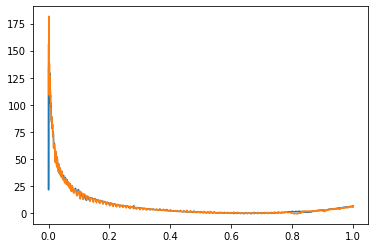

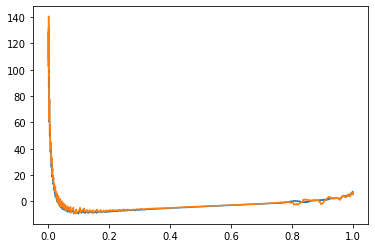

In [110]:
plt.figure()
plt.plot(xnewu,recon[0:1000],xnewu,pdata[0:1000,snapind])

plt.figure()
plt.plot(xnewl,recon[1000:2000],xnewl,pdata[1000:2000,snapind])



[ 3 19]


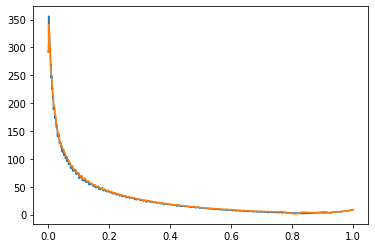

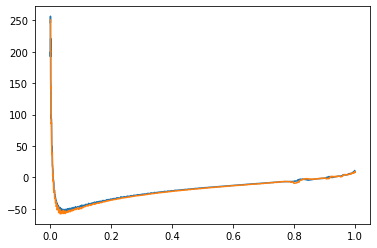

In [107]:
nSensors = 2

Un = U

[q,r,p] = sla.qr(Un,pivoting=True)

sensors = p[0:nSensors]
y = pdata[sensors,snapind]

print(sensors)

a = np.dot(np.linalg.inv(Un[sensors,0:nSensors]),y)
reconopt = np.dot(Un[:,0:nSensors],a)

plt.figure()
plt.plot(xnewu,reconopt[0:1000],xnewu,pdata[0:1000,snapind])

plt.figure()
plt.plot(xnewl,reconopt[1000:2000],xnewl,pdata[1000:2000,snapind])


[[101 287]
 [102 283]
 [103 284]
 [133 321]
 [239 124]
 [ 95 281]
 [302 282]
 [ 94 304]
 [106 329]
 [240 305]
 [107 306]
 [310 318]
 [224 316]
 [223 317]
 [300 319]
 [298 309]
 [222 307]
 [299 308]
 [225 326]
 [134 327]
 [137 331]
 [135 278]
 [126 260]
 [136 258]
 [125 123]
 [208 259]
 [ 14 272]
 [209 311]
 [ 13 110]
 [127 122]
 [290 111]
 [210 251]
 [228 273]
 [211 249]
 [227 250]
 [237 119]
 [229 252]
 [297 303]
 [330 253]
 [173 254]
 [236 263]
 [218 116]
 [172 328]
 [219 261]
 [171 262]
 [226 264]
 [190 115]
 [188 265]
 [ 51 257]
 [189 255]
 [ 50 121]
 [ 53 285]
 [191 256]
 [192 286]
 [ 54 288]
 [220 120]
 [ 16 118]
 [221 289]
 [ 15 117]
 [238 325]
 [ 17 144]
 [ 63 324]
 [ 55 280]
 [ 64 277]
 [  0 323]
 [160 153]
 [161 322]
 [  1 152]
 [212 313]
 [ 52 207]
 [ 73 312]
 [186 314]
 [169 205]
 [174 206]
 [170 113]
 [175 112]
 [ 48 247]
 [193 248]
 [157 114]
 [ 49 279]
 [154  61]
 [156 275]
 [155 274]
 [158  62]
 [194 276]
 [187  88]
 [162 320]
 [230 315]
 [ 23 241]
 [231 143]
 [232 142]

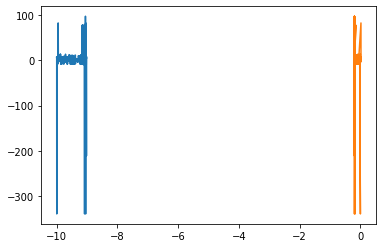

In [224]:
tx = pts[np.argsort(pts[:,0]),0]
pts_chordwise = pts[np.argsort(pts,0)]
print(np.argsort(pts,0))
wingp = (pwing[np.argsort(pts[:,0])])
plt.plot(pts_chordwise[:,0],wingp)

In [96]:
A = np.eye(3)
b = np.array([3, 2, 1]).T
x = np.dot(np.linalg.inv(A),b)
print(x)

[3. 2. 1.]


In [4]:
def getSomeLift():
    import os
    import numpy as np
    dirs = os.listdir('./con/')
    forces = './system/forces'
    for item in dirs:
        os.system('cp {} ./con/{}/system'.format(forces,item))


[0.         0.10333333 0.20333333 0.30666667 0.40377778 0.50111111
 0.59444444 0.72555556 0.84777778 1.07222222 1.05888889 1.14
 1.17888889]


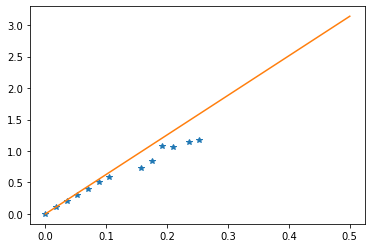

In [12]:
import numpy as np
import matplotlib.pyplot as plt
F = np.array([0, 9.3, 18.3, 27.6, 36.34,45.1,53.5,65.3,76.3,96.5,95.3,102.6,106.1])
v = 15
rho = 1
S = 1 * .8

Cl = F/(.5*v**2*S)
print(Cl)

alpha = np.array([0,1,2,3,4,5,6,9,10,11,12,13.5,14.5])
alpharad = alpha*np.pi/180

test = np.linspace(0,.5,100)
testcl = 2*np.pi*test

plt.plot(alpharad,Cl,'*',test,testcl)

In [56]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pyvista as vtki
caseName = './VTK/12.0_deg.vtk'
wingName = './VTK/wing/12.0_deg.vtk'

# Import raw point data for full grid and wing
grid = vtki.UnstructuredGrid(caseName)
wing = vtki.PolyData(wingName)

grid = grid.cell_data_to_point_data()
print(grid)
# Isolate pressure data from full grid
p_raw = grid['p']
# Isolate <x, y> point data from full grid, and just wing
pts = grid.points

print(np.shape(p_raw),np.shape(pts))
#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.plot3D(pts[:,0],pts[:,1])
#plt.show()

UnstructuredGrid (0x7f12623830a0)
  N Cells:	119943
  N Points:	226993
  X Bounds:	-3.000e+01, 4.000e+01
  Y Bounds:	-1.500e+01, 1.500e+01
  Z Bounds:	2.500e-01, 1.050e+00
  N Arrays:	5

(226993,) (226993, 3)


OverflowError: Too many data points to interpolate

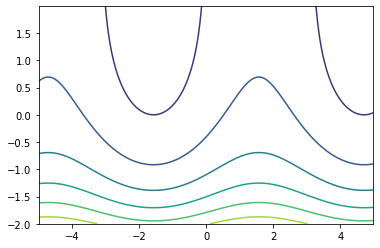

In [59]:
from scipy import interpolate

x = np.arange(-5,5,1e-2)
y = np.arange(-2,2,1e-2)
xx, yy = np.meshgrid(x,y)
z = np.sin(xx)+ np.exp(-yy)

plt.figure()
plt.contour(xx,yy,z)

f = interpolate.interp2d(xx,yy,z,kind='cubic')

plt.figure()
plt.contour(xx,yy,f)

In [19]:
import numpy as np

G = np.array([[3, 1, 1],[2, 0, 1],[1, -1, 1],[3, 1, 0],[2, 0, 0],[1, -1, 0]])

H = G.flatten('C')



[[ 3  1  1]
 [ 2  0  1]
 [ 1 -1  1]
 [ 3  1  0]
 [ 2  0  0]
 [ 1 -1  0]]
[ 3  1  1  2  0  1  1 -1  1  3  1  0  2  0  0  1 -1  0]


In [1]:
p = .5*480**2
print(p)

115200.0
